# Pretraining on unlabelled data

## Installation

This notebook uses code from [elcapo/llm-from-scratch](https://github.com/elcapo/llm-from-scratch/). In order to use it:

```bash
git clone https://github.com/elcapo/llm-from-scratch
cd llm-from-scratch

python -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt

jupyter notebook
```

**Have fun!**

## Where were we?

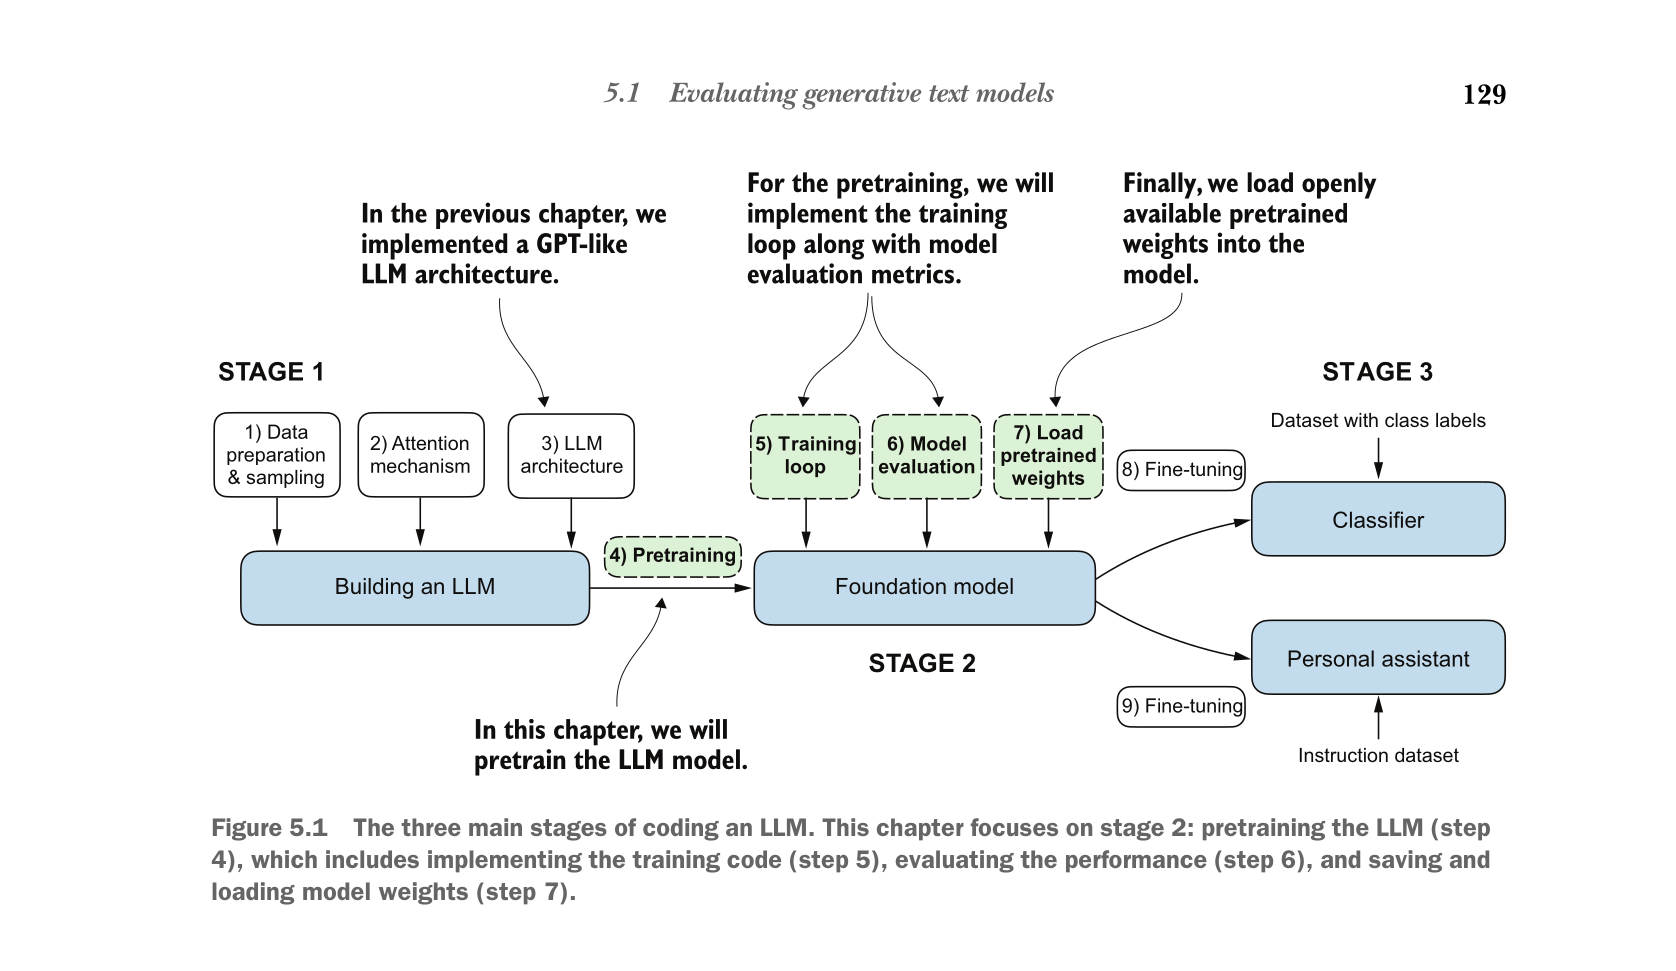

## Where are we going?

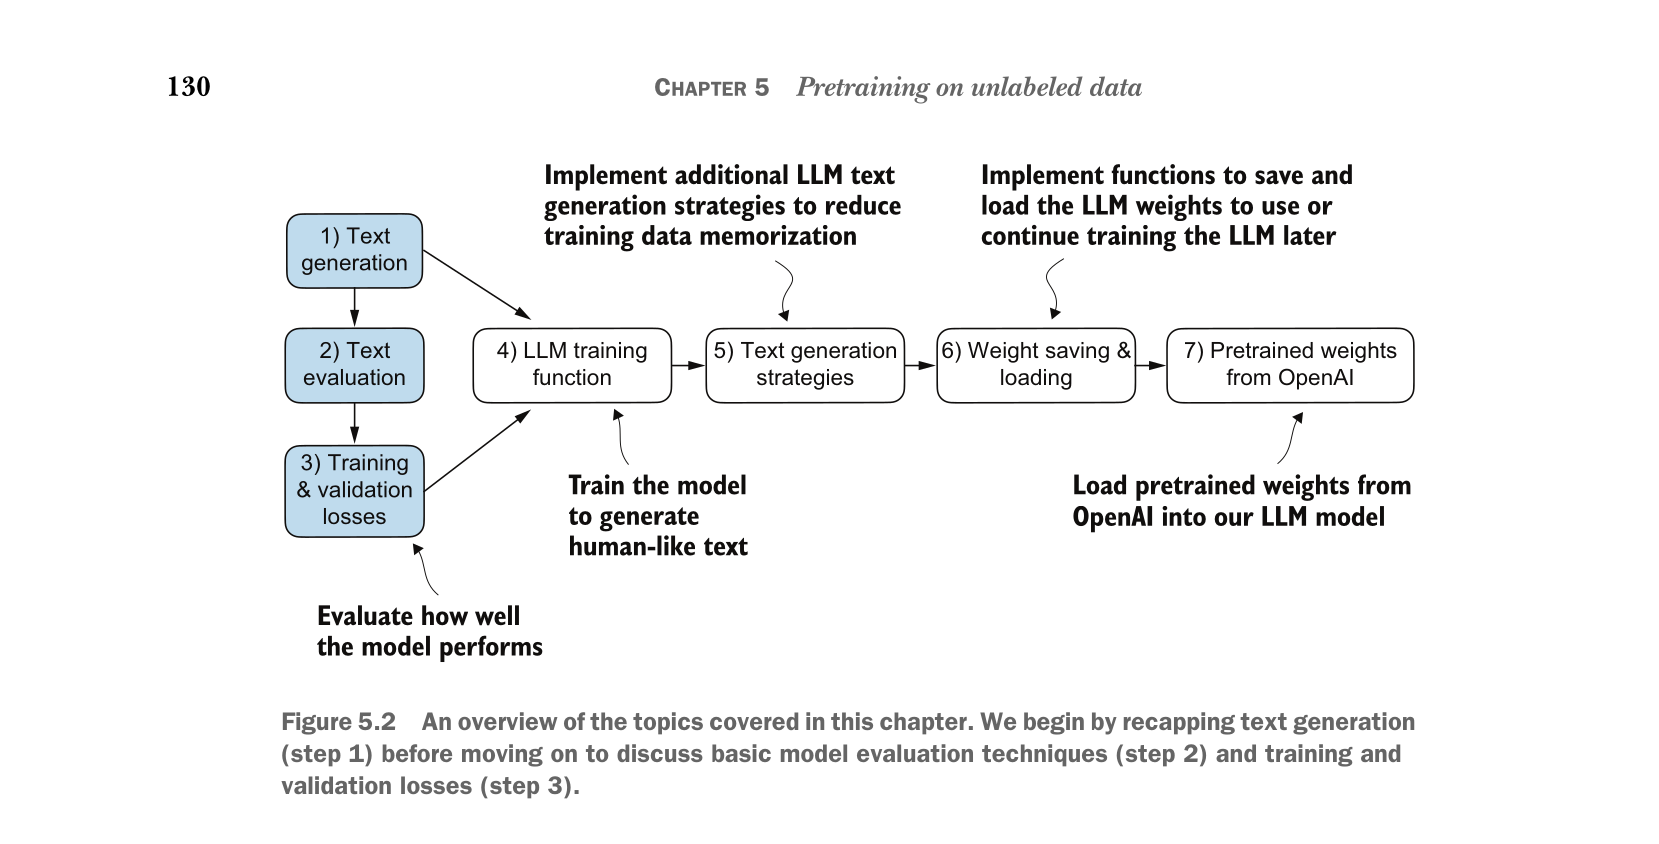

In [2]:
import matplotlib.pyplot as plt
import torch
import warnings

In [6]:
torch.manual_seed(123)
warnings.filterwarnings('ignore')

Let's prepare a tiny input and target to use it to test our model before we feed it with a "real" dataloader.

In [5]:
from scratch.tokenizers.tiktoken_tokenizer import TiktokenTokenizer

tokenizer = TiktokenTokenizer()

inputs = torch.cat(
    (
        tokenizer.text_to_tokens('every effort moves'),
        tokenizer.text_to_tokens('I really like')
    )
)

targets = torch.cat(
    (
        tokenizer.text_to_tokens(' effort moves you'),
        tokenizer.text_to_tokens(' really like chocolate')
    )
)

**Sources**
- [scratch/tokenizers/tiktoken_tokenizer.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/tokenizers/tiktoken_tokenizer.py)
- [scratch/tokenizers/base_tokenizer.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/tokenizers/base_tokenizer.py)

Now, we instantialte a model with the settings of a GPT2 "small" and reduce its context lenght to make it easier for our computer to handle it. We'll set it back to it's original value when we load OpenAI's weights.

In [7]:
from scratch.gpt_config import GptConfig
from scratch.gpt_model import GptModel

config = GptConfig.small()
config.context_length = 256
config.qkv_bias = False

model = GptModel(config)

**Sources**
- [scratch/gpt_config.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/gpt_config.py)
- [scratch/gpt_model.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/gpt_model.py)

We can now get the answer to process our inputs.

In [10]:
with torch.no_grad():
    logits = model(inputs)

**References**
- [torch.no_grad](https://pytorch.org/docs/stable/generated/torch.no_grad.html)

We are using softmax here because we'll use it to make the model to generate different outputs considering a "temperature" setting.

In [10]:
probas = torch.softmax(logits, dim=-1)
token_ids = torch.argmax(probas, dim=-1, keepdim=True)

**References**
- [torch.nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
- [torch.argmax](https://pytorch.org/docs/stable/generated/torch.argmax.html)

But, for the moment, we could obtain the same result without the softmax normalization.

In [7]:
token_ids = torch.argmax(logits, dim=-1, keepdim=True)

Anyway, let's get check the generated text.

In [11]:
for sample_id, target in enumerate(targets):
    print("")
    print("Sample:", sample_id + 1)
    print("- Input:", tokenizer.tokens_to_text(inputs[sample_id]))
    print("- Target:", tokenizer.tokens_to_text(target))
    print("- Output:", tokenizer.tokens_to_text(token_ids[sample_id].flatten()))


Sample: 1
- Input: every effort moves
- Target:  effort moves you
- Output:  Menbage inaction

Sample: 2
- Input: I really like
- Target:  really like chocolate
- Output:  pressuring unf rounding


**References**
- [torch.flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [12]:
for sample_id, target in enumerate(targets):
    log_probas = torch.log(probas[sample_id, [0, 1, 2], targets[sample_id]])
    print("")
    print("Sample:", sample_id + 1)
    print("- Logits:", logits[sample_id, [0, 1, 2], targets[sample_id]].tolist())
    print("- Probabilities:", probas[sample_id, [0, 1, 2], targets[sample_id]].tolist())


Sample: 1
- Logits: [0.9475278854370117, 0.29084622859954834, -0.4265158176422119]
- Probabilities: [4.355938654043712e-05, 2.2607446226174943e-05, 1.1022742910427041e-05]

Sample: 2
- Logits: [-0.2598324418067932, 1.2803632020950317, -1.2533059120178223]
- Probabilities: [1.3012027011427563e-05, 6.039474828867242e-05, 4.806269316759426e-06]


In [13]:
def plot_probabilities(sample_id):
    fig, ax = plt.subplots()

    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    x = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in targets[sample_id]]
    y = probas[sample_id, [0, 1, 2], targets[sample_id]].tolist()
    
    ax.bar(x, y, color='green')
    ax.set_title('Probabilities before training for sample ' + str(sample_id + 1))
    fig.show()

**References**
- [torch.unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html)

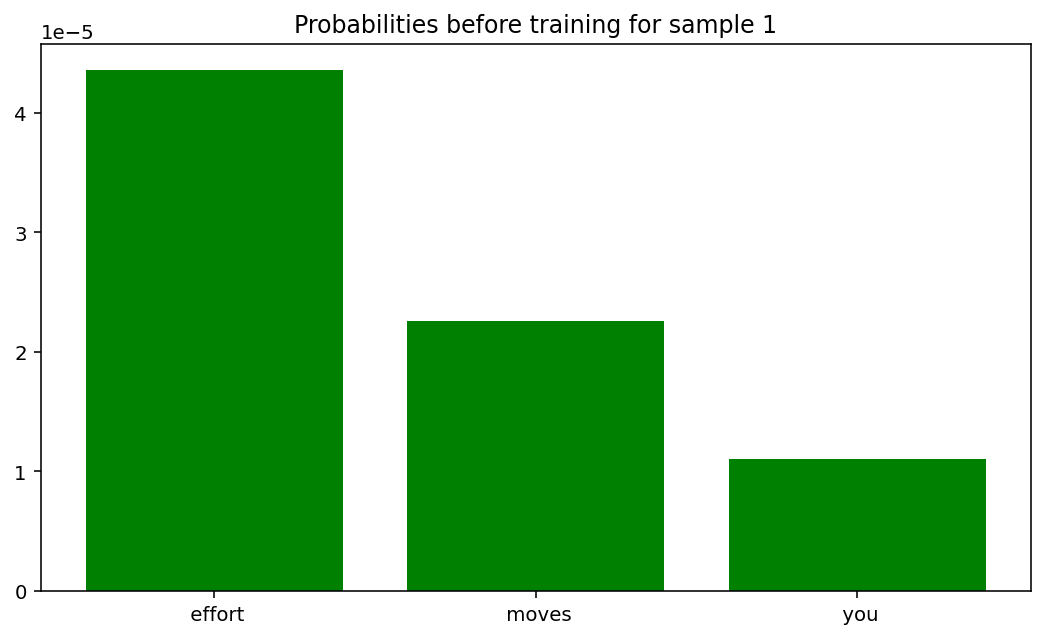

In [14]:
plot_probabilities(sample_id=0)

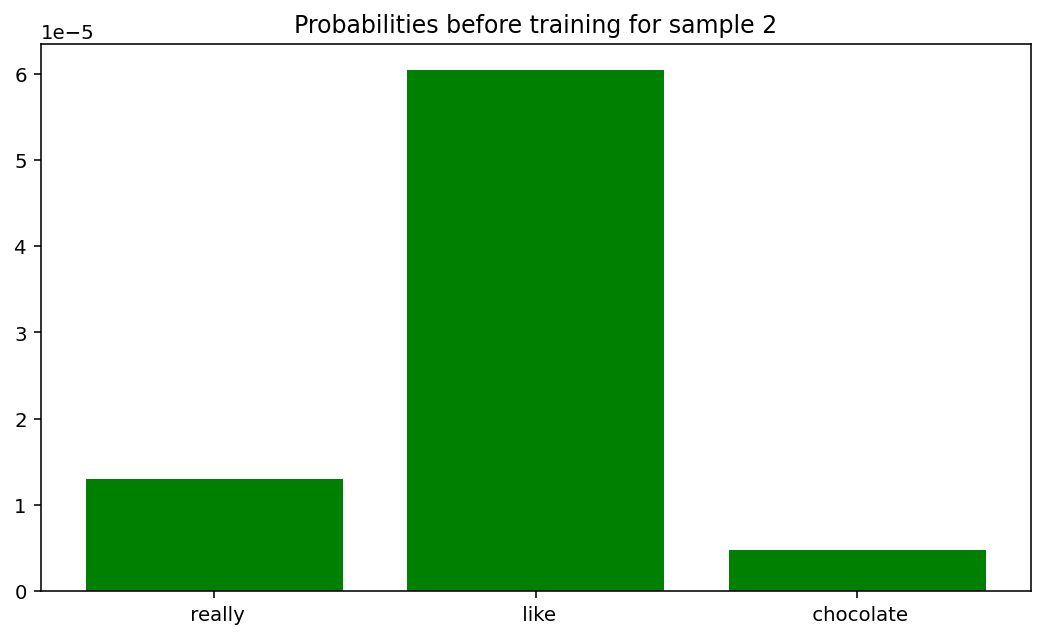

In [15]:
plot_probabilities(sample_id=1)

In [16]:
def plot_contextualized_probabilities(sample_id):
    fig, ax = plt.subplots()

    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    batch_tokens = targets[sample_id]
    other_tokens = torch.randint(0, config.vocab_size - 1, (33,))
    tokens = batch_tokens.tolist() + other_tokens.tolist()

    batch_words = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in batch_tokens]
    other_words = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in other_tokens]
    words = batch_words + other_words
    
    batch_probas = probas[sample_id, [0, 1, 2], batch_tokens].tolist()
    other_probas = probas[sample_id, 0, other_tokens].tolist()
    y = batch_probas + other_probas

    batch_color = ['green' for _ in batch_words]
    other_color = ['red' for _ in other_words]
    c = batch_color + other_color
    
    ax.bar(words, y, color=c)
    ax.set_title('Probabilities before training for sample ' + str(sample_id + 1))
    ax.set_xticklabels(words, rotation=75)
    fig.show()

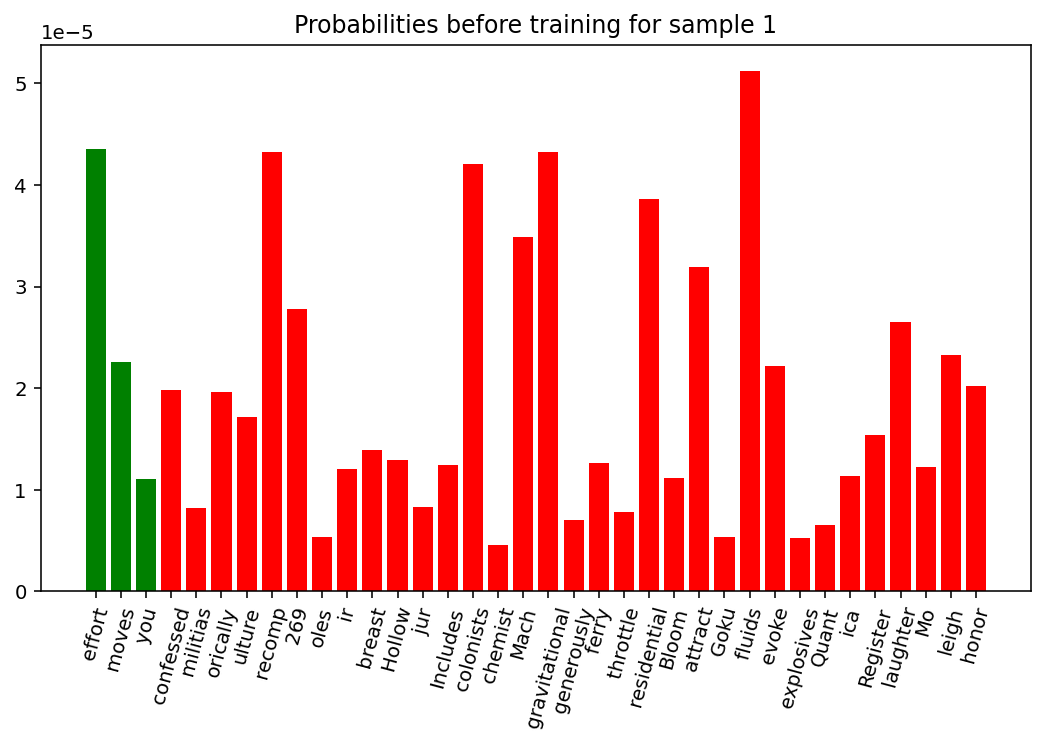

In [18]:
plot_contextualized_probabilities(sample_id=0)

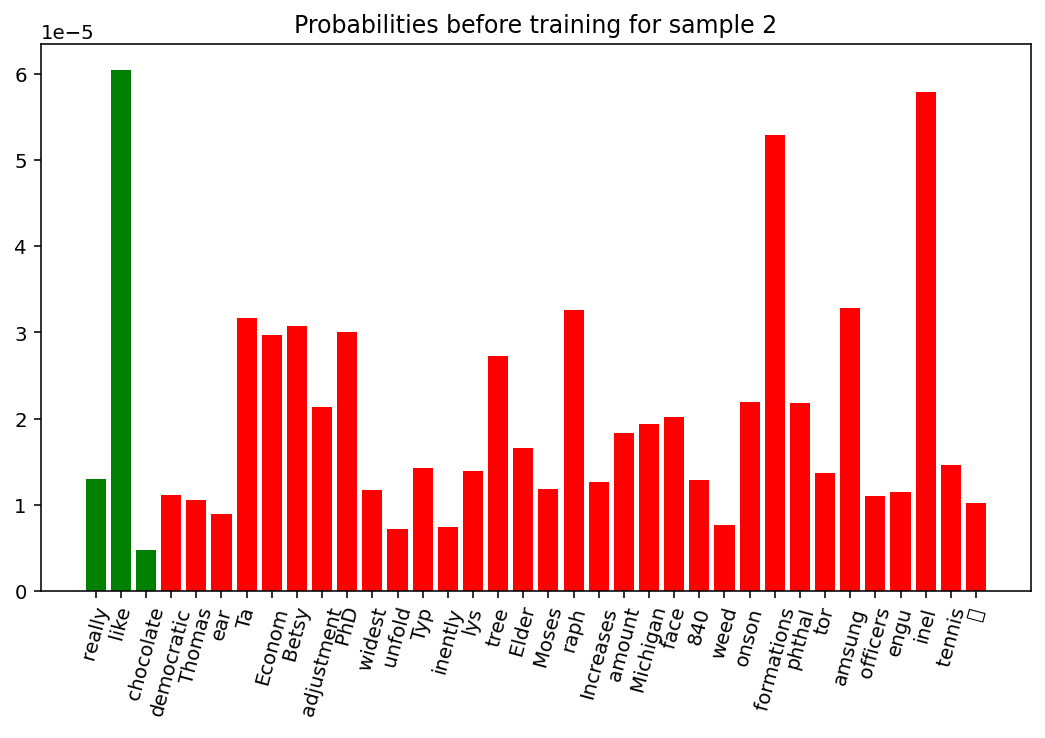

In [19]:
plot_contextualized_probabilities(sample_id=1)

## Text evaluation

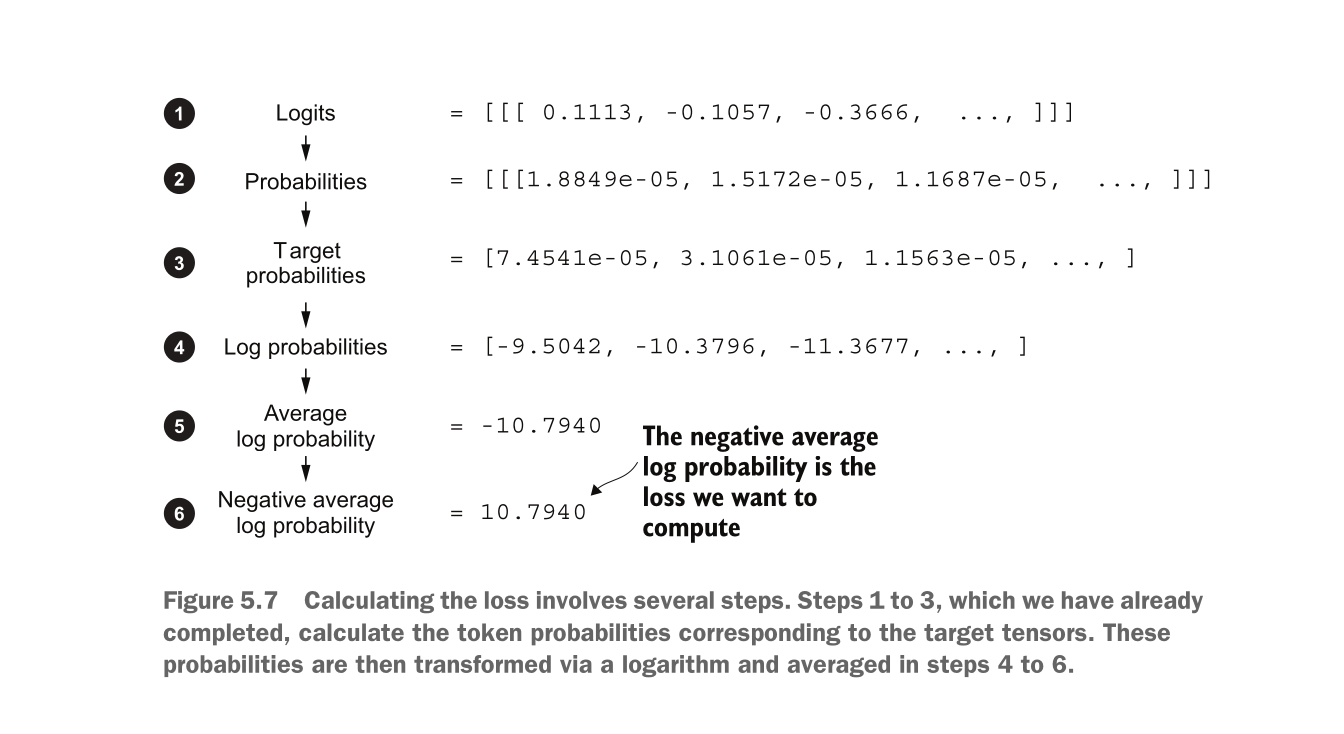

In [20]:
def print_loss(sample_id):
    batch_probas = probas[sample_id, [0, 1, 2], targets[sample_id]]
    log_probas = torch.log(batch_probas)
    print()
    print("Sample:", sample_id + 1)
    print("- Logits:", logits[sample_id, [0, 1, 2], targets[sample_id]].tolist())
    print("- Probabilities:", probas[sample_id, [0, 1, 2], targets[sample_id]].tolist())
    print("- Logarithm of the probabilities:", log_probas)
    print("- Average of the logarithm", torch.mean(log_probas))
    print("- Negative average of the logarithm", -torch.mean(log_probas))

print_loss(sample_id=0)
print_loss(sample_id=1)

print()
print("Overall:")

all_probas = torch.cat(
    (
        probas[0, [0, 1, 2], targets[0]],
        probas[1, [0, 1, 2], targets[1]]
    )
)

all_log_probas = torch.log(all_probas)

print("- Probabilities:", all_probas)
print("- Logarithm of the probabilities:", all_log_probas)
print("- Average of the logarithm", torch.mean(all_log_probas))
print("- Negative average of the logarithm", -torch.mean(all_log_probas))


Sample: 1
- Logits: [0.9475278854370117, 0.29084622859954834, -0.4265158176422119]
- Probabilities: [4.355938654043712e-05, 2.2607446226174943e-05, 1.1022742910427041e-05]
- Logarithm of the probabilities: tensor([-10.0414, -10.6972, -11.4156])
- Average of the logarithm tensor(-10.7181)
- Negative average of the logarithm tensor(10.7181)

Sample: 2
- Logits: [-0.2598324418067932, 1.2803632020950317, -1.2533059120178223]
- Probabilities: [1.3012027011427563e-05, 6.039474828867242e-05, 4.806269316759426e-06]
- Logarithm of the probabilities: tensor([-11.2496,  -9.7146, -12.2456])
- Average of the logarithm tensor(-11.0699)
- Negative average of the logarithm tensor(11.0699)

Overall:
- Probabilities: tensor([4.3559e-05, 2.2607e-05, 1.1023e-05, 1.3012e-05, 6.0395e-05, 4.8063e-06])
- Logarithm of the probabilities: tensor([-10.0414, -10.6972, -11.4156, -11.2496,  -9.7146, -12.2456])
- Average of the logarithm tensor(-10.8940)
- Negative average of the logarithm tensor(10.8940)


**References**
- [torch.log](https://pytorch.org/docs/stable/generated/torch.log.html)
- [torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html)
- [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html)

In [17]:
torch.nn.functional.cross_entropy(logits.flatten(0, 1), targets.flatten())

tensor(10.8940)

**References**
- [torch.nn.functional.cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html)

Sounds good but...
- Why are we taking a logarithm?
- Why are we computing an average?
- Why are we switching the sign?

### Logistic regression

Given $h(x)$ as the last activation function, we want a function that separates the "right" values and "wrong" ones, like this:

$$
  P(y|\boldsymbol{x}) = \left\{\def\arraystretch{1.2}%
  \begin{array}{@{}c@{\quad}l@{}}
    h(\boldsymbol{x}) & y = 1 \\
    1 - h(\boldsymbol{x}) & y = 0 \\
  \end{array}\right.
$$

A function that satisfies that, is:

$$
P(y|\boldsymbol{x}) = h(\boldsymbol{x})^y · (1 - h(\boldsymbol{x}))^{1 - y}
$$

For multiple training examples, we want to maximize their overall probability.

As those are independent events, their probabilities multiply:

$$
P(y_1, ..., y_n | \boldsymbol{x}_i, ..., \boldsymbol{x}_n) = \prod_{i=1}^n P(y_i | \boldsymbol{x}_i)
$$

Which is the same as maximizing its logarithm, only that with the logarithm we have to maximise an addition rather than a multiplication.

We added a negative sign because PyTorch comes bundled with functions to minimize gradients.

$$
\mathcal{L} = - \sum_{i=1}^{n} y_i · log(p_i)
$$

Since only the correct tokens contribute to the addition (as $y_i = 0$ for the other ones), the expression can be simplified to:

$$
\mathcal{L} = - log(p_y)
$$

Finally, for a sequence of tokens, the loss is computed as the average or sum of the cross-entropy losses for all predicted tokens in the sequence:

$$
\mathcal{L}_{seq} = \frac{1}{n} \sum_{i=1}^{n} - log(p_{y_i})
$$

#### Sources
- [Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM) by Sebastian Raschka (2021)

## Training and validation losses

Now, to start preparing a real data loader, let's read "The Veredict".

In [21]:
file_path = "tests/fixtures/the-veredict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

print("Total characters", len(text_data))
print("Total tokens", len(tokenizer.encode(text_data)))

Total characters 20480
Total tokens 5146


... and let's split it into two training and validation sets.

In [22]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
validation_data = text_data[split_idx:]

Now, we'll use it to feed the dataloader from chapter 2.

In [23]:
from scratch.dataloader import create_dataloader

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0)

validation_loader = create_dataloader(
    validation_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0)

**Sources**
- [scratch/dataloader.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/dataloader.py)

In [24]:
print("Train loader")
for x, y in train_loader:
    print("- ", x.shape, y.shape)

print("")
print("Validation loader")
for x, y in validation_loader:
    print("- ", x.shape, y.shape)

Train loader
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])

Validation loader
-  torch.Size([1, 256]) torch.Size([1, 256])


Let's now check how our untrained model performs.

In [25]:
from scratch.training.loader_loss import LoaderLoss

loader_loss = LoaderLoss(model)

with torch.no_grad():
    train_loss = loader_loss.calc(train_loader)
    validation_loss = loader_loss.calc(validation_loader)

print("Training loss", train_loss)
print("Validation loss", validation_loss)

Training loss 10.991989850997925
Validation loss 10.991188049316406


**Sources**
- [scratch/training/batch_loss.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/training/batch_loss.py)
- [scratch/training/loader_loss.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/training/loader_loss.py)

## LLM training function

First let's intantiate an optimizer, which is what will take care of updating the model weights whenever we calculate loss.

In [26]:
# Instantiate the model here to reinitiate its weights every time this cell is executed
config = GptConfig.small()
config.context_length = 256
config.qkv_bias = False

model = GptModel(config)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 0.0004,
    weight_decay = 0.1)

Now, let's instantiate our trainer.

In [28]:
from scratch.training.simple_trainer import SimpleTrainer

trainer = SimpleTrainer(
    model,
    train_loader,
    validation_loader,
    optimizer,
    tokenizer)

**References**
- [torch.optim.AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)

**Sources**
- [scratch/training/simple_trainer.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/training/simple_trainer.py)

Finally! This is what we are here for! Let's train our model.

In [29]:
num_epochs = 10

train_losses, validation_losses, tokens_seen = trainer.train(
    num_epochs = num_epochs,
    eval_freq = 5,
    eval_iter = 5,
    start_context = "Every effort moves you")

Epoch 1
- Step 0
- Train loss 9.852434349060058
- Evaluation loss 10.147008895874023
Epoch 1
- Step 5
- Train loss 8.071284103393555
- Evaluation loss 8.278226852416992
Every effort moves you.                                                 
Epoch 2
- Step 10
- Train loss 6.700366592407226
- Evaluation loss 7.0982537269592285
Epoch 2
- Step 15
- Train loss 6.012231922149658
- Evaluation loss 6.620536804199219
Every effort moves you.                                                 
Epoch 3
- Step 20
- Train loss 5.848544025421143
- Evaluation loss 6.4442596435546875
Every effort moves you of the of the of the of the of the, and.        " I. ". " I. " I. " I, and, and, and.   " I
Epoch 4
- Step 25
- Train loss 5.6236443519592285
- Evaluation loss 6.518649101257324
Epoch 4
- Step 30
- Train loss 5.366181373596191
- Evaluation loss 6.521543502807617
Every effort moves youburn, and in the--as, and I had the, and I had, and--and, and in the had, and, and in the--, and to the, and, and, and, 

In [30]:
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_looses, validation_looses):
    fig, ax1 = plt.subplots(figsize=(5,3))

    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    ax1.plot(epochs_seen, train_looses, label="Training loss")
    ax1.plot(epochs_seen, validation_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

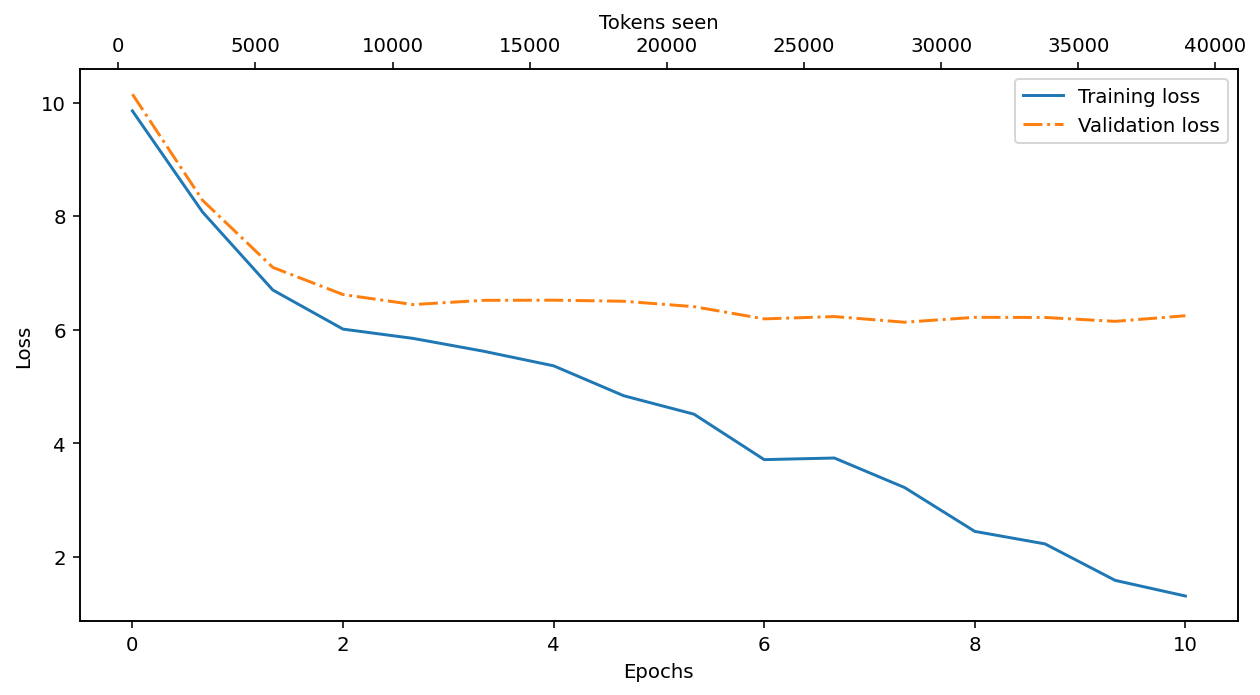

In [31]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, validation_losses)

## Text generation strategies

For a given pretrained model, we'd always obtain the same output if we executed this several times:

In [37]:
from scratch.generators.simple_text_generator import SimpleTextGenerator

inputs = tokenizer.text_to_tokens("Every effort moves you").to("cuda")
generator = SimpleTextGenerator(model, max_new_tokens=25)
logits = generator.generate(inputs)
output = tokenizer.tokens_to_text(logits)

print("Output:", output)

Output: Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




**Sources**
- [scratch/generators/simple_text_generator.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/generators/simple_text_generator.py)

This is a simpler example show casing the same thing. We'll always obtain "forward":

In [41]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

print(inverse_vocab[next_token_id])

forward


In [43]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(freq.item(), "->", inverse_vocab[i])

def plot_probas(probas, words, title, color='green'):
    fig, ax = plt.subplots()

    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    x = torch.arange(len(words))
    ax.bar(x, probas, color=color)
    ax.set_title(title)
    ax.set_ylabel('Probability')
    ax.set_xticks(x)
    ax.set_xticklabels(words, rotation=75)
    fig.show()

**References**
- [torch.multinomial](https://pytorch.org/docs/stable/generated/torch.multinomial.html)
- [torch.bincount](https://pytorch.org/docs/stable/generated/torch.bincount.html)

### Temperature scaling

We'll now see how we can tweak the softmax function to make it help us getting different results each time.

In [45]:
def softmax_with_temperature(logits, temperature = 1):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

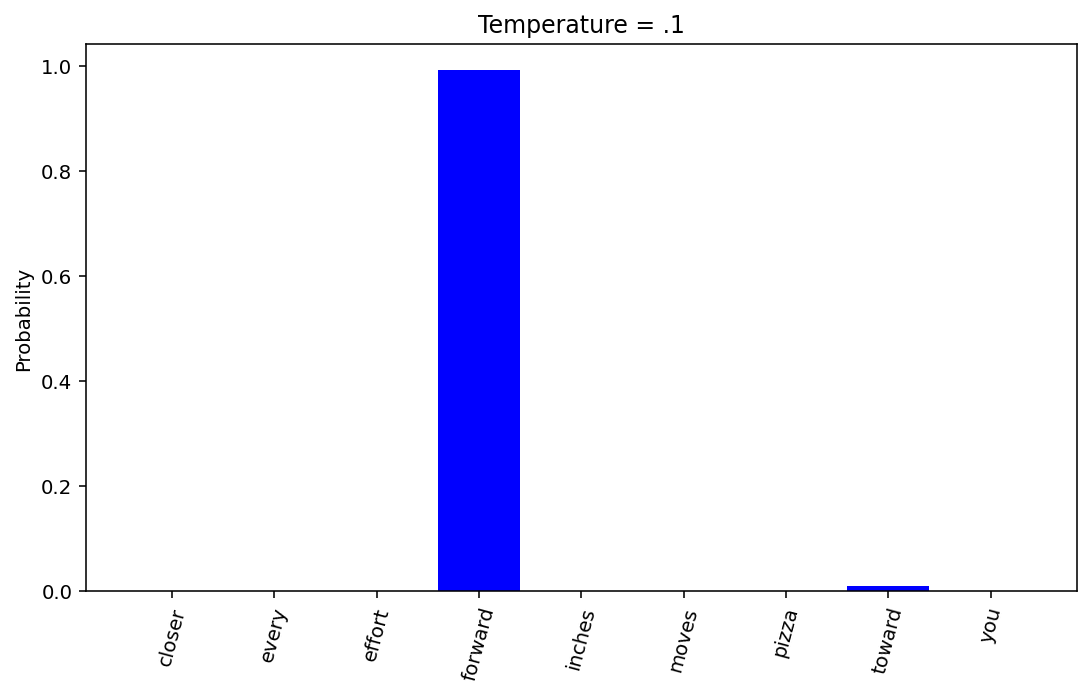

In [46]:
plot_probas(
    softmax_with_temperature(next_token_logits, .1),
    vocab.keys(),
    "Temperature = .1",
    "blue"
)

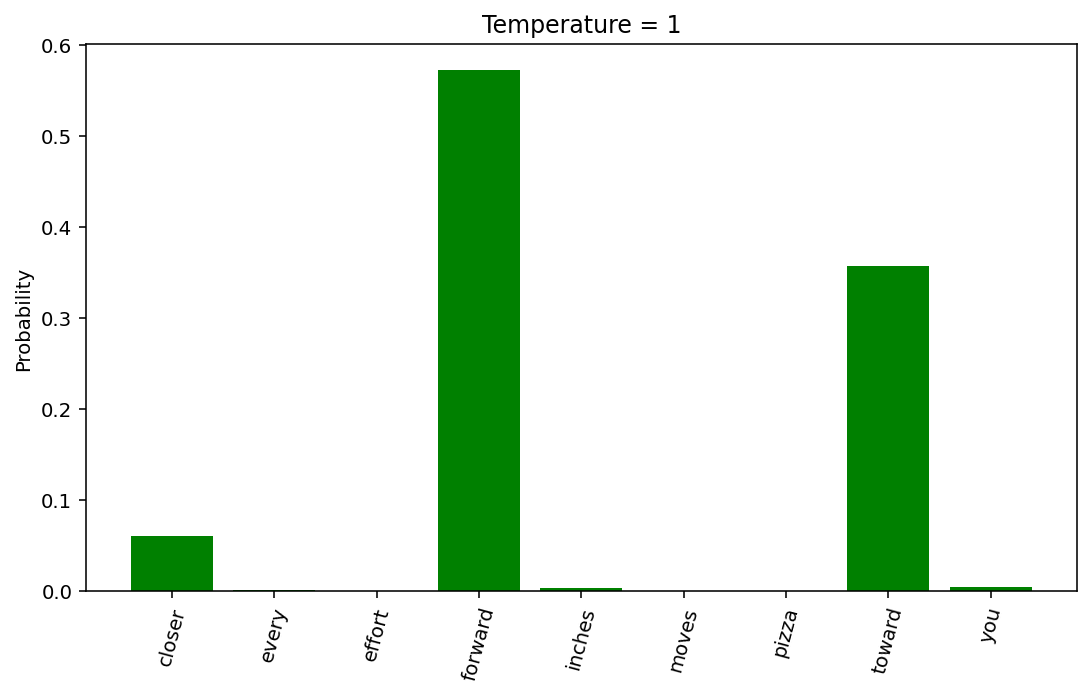

In [33]:
plot_probas(
    softmax_with_temperature(next_token_logits, 1),
    vocab.keys(),
    "Temperature = 1",
    "green"
)

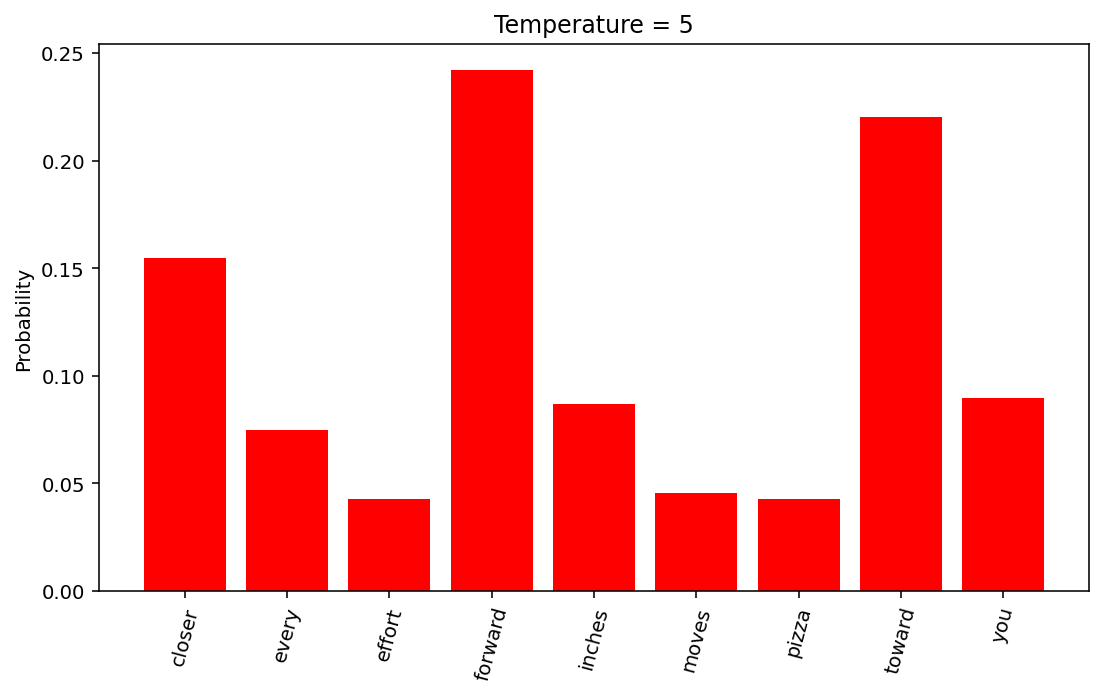

In [34]:
plot_probas(
    softmax_with_temperature(next_token_logits, 5),
    vocab.keys(),
    "Temperature = 5",
    "red"
)

### Top-k sampling

In combination with temperature scaling, top-k sampling can enrich our text generation.

In [47]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)
print("Top 3 words:", [inverse_vocab[pos.item()] for pos in top_pos])

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
Top 3 words: ['forward', 'toward', 'closer']


**Reference**
- [torch.topk](https://pytorch.org/docs/main/generated/torch.topk.html)

In [48]:
from scratch.generators.probabilistic_text_generator import ProbabilisticTextGenerator

inputs = tokenizer.text_to_tokens("Every effort moves you").to("cuda")
generator = ProbabilisticTextGenerator(model, max_new_tokens=25, top_k=25, temperature=1.4)

for _ in range(10):
    logits = generator.generate(inputs)
    output = tokenizer.tokens_to_text(logits)
    print("-", output.replace("\n", " "))

- Every effort moves you of he ch his eyes pushed one--his I can so dis. He him-- so that nearly a tempting?" "interesting
- Every effort moves you stand through I touched that point for him better; and in on the of the all and."  Of. Well
- Every effort moves you?" Poor garland I said, my host, as the the picture_ his own dis about her that thing he was
- Every effort moves you circulation," was one of the terrace of "The fact, as in a vindicated--she's by, in delicate
- Every effort moves you in."    For." "What the irony see his pictures charming. The, by here slight shade of
- Every effort moves you strokes escape through the picture, in the picture--I told Mrs. Sheres and silver of an comfortable him-- I
- Every effort moves you in I had not that; but by the fact an and Mrs. Andhad not till--so thought of " fullestly
- Every effort moves you. Rick Gisburn's I, had myself Jack Stroud, so charming the own about Miss Croft on, Jack
- Every effort moves you say that never werely, one 

**Sources**
- [scratch/generators/probabilistic_text_generator.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/generators/probabilistic_text_generator.py)

## Weight saving and loading in PyTorch

### Saving the weights

The easiest way to save our model weights at this point is to use PyTorch's `save` function.

In [49]:
torch.save(model.state_dict(), "state/model.pth")

**References**
- [torch.save](https://pytorch.org/docs/stable/generated/torch.save.html)
- [torch.nn.Module.state_dict](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict)

This will work but our optimizer also has weights that aren't stored this way. To also save them, we can do:

In [50]:
torch.save({
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}, "state/model_and_optimizer.pth")

### Loading the weights

To load the stored weights, we first need to instantiate a model with the same parameters.

In [51]:
config = GptConfig.small()
config.context_length = 256
config.qkv_bias = False

loaded_model = GptModel(config)

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.load_state_dict(torch.load("state/model.pth", map_location=device))

<All keys matched successfully>

**References**
- [torch.load](https://pytorch.org/docs/stable/generated/torch.load.html)
- [torch.nn.Module.load_state_dict](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.load_state_dict)

As before, to load their weights, we need to instantiate a model and an optimizer with the same parameters used to save them.

In [53]:
config = GptConfig.small()
config.context_length = 256
config.qkv_bias = False

model = GptModel(config)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 0.0004,
    weight_decay = 0.1)

Finally, we can load both the stored weights of the model and the optimizer:

In [54]:
checkpoint = torch.load("state/model_and_optimizer.pth", map_location=device)
loaded_model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

## Loading pretrained weights from OpenAI

In [55]:
from scratch.gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size="124M", models_dir="state/gpt2")

2024-12-15 15:12:32.824401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734275552.837750   11373 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734275552.840887   11373 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 15:12:32.852169: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: state/gpt2/124M/checkpoint
File already exists and is up-to-date: state/gpt2/124M/encoder.json
File already exists and is up-to-date: state/gpt2/124M/hparams.json
File already exists and is up-to-date: state/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: state/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: state/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: state/gpt2/124M/vocab.bpe


In [56]:
config = GptConfig.small()
gpt = GptModel(config)
gpt.eval()

GptModel(
  (token_embeddings): Embedding(50257, 768)
  (positional_embeddings): Embedding(1024, 768)
  (dropout_embeddings): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (normalizer): SoftmaxNormalizer()
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): Gelu()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inp

In [58]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError("Shape mismatch. Left:", left.shape, "Right:", right.shape)
    return torch.nn.Parameter(torch.tensor(right))

In [59]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.token_embeddings.weight = assign(gpt.token_embeddings.weight, params['wte'])
    gpt.positional_embeddings.weight = assign(gpt.positional_embeddings.weight, params['wpe'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.weight = assign(
            gpt.transformer_blocks[b].attention.W_query.weight, q_w.T)
        gpt.transformer_blocks[b].attention.W_key.weight = assign(
            gpt.transformer_blocks[b].attention.W_key.weight, k_w.T)
        gpt.transformer_blocks[b].attention.W_value.weight = assign(
            gpt.transformer_blocks[b].attention.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.bias = assign(
            gpt.transformer_blocks[b].attention.W_query.bias, q_b)
        gpt.transformer_blocks[b].attention.W_key.bias = assign(
            gpt.transformer_blocks[b].attention.W_key.bias, k_b)
        gpt.transformer_blocks[b].attention.W_value.bias = assign(
            gpt.transformer_blocks[b].attention.W_value.bias, v_b)

        gpt.transformer_blocks[b].attention.out_proj.weight = assign(
            gpt.transformer_blocks[b].attention.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].attention.out_proj.bias = assign(
            gpt.transformer_blocks[b].attention.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_blocks[b].feed_forward.layers[0].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[0].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].feed_forward.layers[2].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[2].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_blocks[b].normalization1.scale = assign(
            gpt.transformer_blocks[b].normalization1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].normalization1.shift = assign(
            gpt.transformer_blocks[b].normalization1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].normalization2.scale = assign(
            gpt.transformer_blocks[b].normalization2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].normalization2.shift = assign(
            gpt.transformer_blocks[b].normalization2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_normalization.scale = assign(gpt.final_normalization.scale, params["g"])
    gpt.final_normalization.shift = assign(gpt.final_normalization.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

load_weights_into_gpt(gpt, params)
gpt.to(device)

GptModel(
  (token_embeddings): Embedding(50257, 768)
  (positional_embeddings): Embedding(1024, 768)
  (dropout_embeddings): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (normalizer): SoftmaxNormalizer()
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): Gelu()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inp

In [60]:
from scratch.generators.probabilistic_text_generator import ProbabilisticTextGenerator

inputs = tokenizer.text_to_tokens("Every effort moves you").to("cuda")
generator = ProbabilisticTextGenerator(gpt, max_new_tokens=25, top_k=25, temperature=1.4)

for _ in range(10):
    logits = generator.generate(inputs)
    output = tokenizer.tokens_to_text(logits)
    print("-", output.replace("\n", " "))

- Every effort moves you up. I am sorry and I am sorry that you need to see that and I am still praying we have a good relationship
- Every effort moves you out of your body.  You are going to do more, you're going to do more. It will take a
- Every effort moves you through all the elements.  A: I think if we start from a very general point of view, it doesn't
- Every effort moves you through your life.  This is an emotional story. You don't realize you're dealing with a disease or a mental
- Every effort moves you towards something other than "your", where you think it's better or worse than whatever the world wants, it gets harder,
- Every effort moves you around and the results you get can never match the value you create! This can be used to build amazing communities and you have
- Every effort moves you along in order to achieve the goal set in mind. The same goes, if you're able to stay focused. The point
- Every effort moves you slowly towards a goal or a goal does not have a de

In [61]:
torch.save(gpt.state_dict(), "state/gpt2.pth")